In [1]:
import mediapipe as mp
import cv2
import numpy as np
import pandas as pd
import csv
import os
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Drawing helpers
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

objc[30090]: Class CaptureDelegate is implemented in both /Users/fuixlabsdev1/Programming/PP/graduation-thesis/env/lib/python3.8/site-packages/mediapipe/.dylibs/libopencv_videoio.3.4.16.dylib (0x105748860) and /Users/fuixlabsdev1/Programming/PP/graduation-thesis/env/lib/python3.8/site-packages/cv2/cv2.abi3.so (0x281476480). One of the two will be used. Which one is undefined.
objc[30090]: Class CVWindow is implemented in both /Users/fuixlabsdev1/Programming/PP/graduation-thesis/env/lib/python3.8/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x103b10a68) and /Users/fuixlabsdev1/Programming/PP/graduation-thesis/env/lib/python3.8/site-packages/cv2/cv2.abi3.so (0x2814764d0). One of the two will be used. Which one is undefined.
objc[30090]: Class CVView is implemented in both /Users/fuixlabsdev1/Programming/PP/graduation-thesis/env/lib/python3.8/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x103b10a90) and /Users/fuixlabsdev1/Programming/PP/graduation-th

## 1. Build dataset from collected video

### 1.1. Determine important landmarks for lunge and set up important functions

There are 3 stages for every lunge exercise
- INIT (I): stand straight
- MID (M): Before go down 
- DOWN (D): Go down

In [2]:
# Determine important landmarks for lunge
IMPORTANT_LMS = [
    "NOSE",
    "LEFT_SHOULDER",
    "RIGHT_SHOULDER",
    "LEFT_HIP",
    "RIGHT_HIP",
    "LEFT_KNEE",
    "RIGHT_KNEE",
    "LEFT_ANKLE",
    "RIGHT_ANKLE",
    "LEFT_HEEL",
    "RIGHT_HEEL",
    "LEFT_FOOT_INDEX",
    "RIGHT_FOOT_INDEX",
]

# Generate all columns of the data frame

HEADERS = ["label"] # Label column

for lm in IMPORTANT_LMS:
    HEADERS += [f"{lm.lower()}_x", f"{lm.lower()}_y", f"{lm.lower()}_z", f"{lm.lower()}_v"]

In [3]:
def rescale_frame(frame, percent=50):
    '''
    Rescale a frame to a certain percentage compare to its original frame
    '''
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
    

def init_csv(dataset_path: str):
    '''
    Create a blank csv file with just columns
    '''

    # Ignore if file is already exist
    if os.path.exists(dataset_path):
        return

    # Write all the columns to a empty file
    with open(dataset_path, mode="w", newline="") as f:
        csv_writer = csv.writer(f, delimiter=",", quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow(HEADERS)


def export_landmark_to_csv(dataset_path: str, results, action: str) -> None:
    '''
    Export Labeled Data from detected landmark to csv
    '''
    landmarks = results.pose_landmarks.landmark
    keypoints = []

    try:
        # Extract coordinate of important landmarks
        for lm in IMPORTANT_LMS:
            keypoint = landmarks[mp_pose.PoseLandmark[lm].value]
            keypoints.append([keypoint.x, keypoint.y, keypoint.z, keypoint.visibility])
        
        keypoints = list(np.array(keypoints).flatten())

        # Insert action as the label (first column)
        keypoints.insert(0, action)

        # Append new row to .csv file
        with open(dataset_path, mode="a", newline="") as f:
            csv_writer = csv.writer(f, delimiter=",", quotechar='"', quoting=csv.QUOTE_MINIMAL)
            csv_writer.writerow(keypoints)
        

    except Exception as e:
        print(e)
        pass


def describe_dataset(dataset_path: str):
    '''
    Describe dataset
    '''

    data = pd.read_csv(dataset_path)
    print(f"Headers: {list(data.columns.values)}")
    print(f'Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}\n')
    print(f"Labels: \n{data['label'].value_counts()}\n")
    print(f"Missing values: {data.isnull().values.any()}\n")
    
    duplicate = data[data.duplicated()]
    print(f"Duplicate Rows : {len(duplicate.sum(axis=1))}")

    return data


def remove_duplicate_rows(dataset_path: str):
    '''
    Remove duplicated data from the dataset then save it to another files
    '''
    
    df = pd.read_csv(dataset_path)
    df.drop_duplicates(keep="first", inplace=True)
    df.to_csv(f"cleaned_dataset.csv", sep=',', encoding='utf-8', index=False)
    

def concat_csv_files_with_same_headers(file_paths: list, saved_path: str):
    '''
    Concat different csv files
    '''
    all_df = []
    for path in file_paths:
        df = pd.read_csv(path, index_col=None, header=0)
        all_df.append(df)
    
    results = pd.concat(all_df, axis=0, ignore_index=True)
    results.to_csv(saved_path, sep=',', encoding='utf-8', index=False)


def calculate_angle(point1: list, point2: list, point3: list) -> float:
    '''
    Calculate the angle between 3 points
    Unit of the angle will be in Degree
    '''
    point1 = np.array(point1)
    point2 = np.array(point2)
    point3 = np.array(point3)

    # Calculate algo
    angleInRad = np.arctan2(point3[1] - point2[1], point3[0] - point2[0]) - np.arctan2(point1[1] - point2[1], point1[0] - point2[0])
    angleInDeg = np.abs(angleInRad * 180.0 / np.pi)

    angleInDeg = angleInDeg if angleInDeg <= 180 else 360 - angleInDeg
    return angleInDeg

### 1.2. Extract data from video for train set

In [41]:
DATASET_PATH = "stage.train.csv"

cap = cv2.VideoCapture("../data/lunge/lunge_1.mp4")
save_counts = 0

# init_csv(DATASET_PATH)

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.8) as pose:
    while cap.isOpened():
        ret, image = cap.read()

        if not ret:
            break

        # Reduce size of a frame
        image = rescale_frame(image, 50)
        image = cv2.flip(image, 1)

        video_dimensions = [image.shape[1], image.shape[0]]

        # Recolor image from BGR to RGB for mediapipe
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = pose.process(image)
        
        if not results.pose_landmarks: continue

        landmarks = results.pose_landmarks.landmark

        # Calculate right knee angle
        right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
        right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
        right_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]
        right_knee_angle = calculate_angle(right_hip, right_knee, right_ankle)

        # Calculate left knee angle
        left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
        left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
        left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]
        left_knee_angle = calculate_angle(left_hip, left_knee, left_ankle)

        # Recolor image from BGR to RGB for mediapipe
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw landmarks and connections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, mp_drawing.DrawingSpec(color=(244, 117, 66), thickness=2, circle_radius=4), mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

        # Display the saved count
        cv2.putText(image, f"Saved: {save_counts}", (50, 50), cv2.FONT_HERSHEY_COMPLEX, 2, (0, 0, 0), 2, cv2.LINE_AA)

        # Visualize angles
        cv2.putText(image, str(int(right_knee_angle)), tuple(np.multiply(right_knee, video_dimensions).astype(int)), cv2.FONT_HERSHEY_COMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(image, str(int(left_knee_angle)), tuple(np.multiply(left_knee, video_dimensions).astype(int)), cv2.FONT_HERSHEY_COMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

        cv2.imshow("CV2", image)

        # Pressed key for action
        k = cv2.waitKey(1) & 0xFF

        # * Press I to save as INIT stage
        if k == ord('i'): 
            export_landmark_to_csv(DATASET_PATH, results, "I")
            save_counts += 1
        # * Press M to save as MID stage
        elif k == ord("m"):
            export_landmark_to_csv(DATASET_PATH, results, "M")
            save_counts += 1
        # * Press D to save as DOWN stage
        elif k == ord("d"):
            export_landmark_to_csv(DATASET_PATH, results, "D")
            save_counts += 1

        # Press q to stop
        elif k == ord("q"):
            break
        else: continue

    cap.release()
    cv2.destroyAllWindows()

    # (Optional)Fix bugs cannot close windows in MacOS (https://stackoverflow.com/questions/6116564/destroywindow-does-not-close-window-on-mac-using-python-and-opencv)
    for i in range (1, 5):
        cv2.waitKey(1)
        

In [42]:
df = describe_dataset(DATASET_PATH)
df.tail(3)

# remove_duplicate_rows(DATASET_PATH)

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v', 'left_heel_x', 'left_heel_y', 'left_heel_z', 'left_heel_v', 'right_heel_x', 'right_heel_y', 'right_heel_z', 'right_heel_v', 'left_foot_index_x', 'left_foot_index_y', 'left_foot_index_z', 'left_foot_index_v', 'right_foot_index_x', 'right_foot_index_y', 'right_foot_index_z', 'right_foot_index_v']
Number of rows: 24244 
Number of columns: 53

Labels: 
D    8232
M    8148
I    7864
Name: label, dtype: int64

Missi

,label,nose_x,nose_y,nose_z,nose_v,left_shoulder_x,left_shoulder_y,left_shoulder_z,left_shoulder_v,right_shoulder_x,...,right_heel_z,right_heel_v,left_foot_index_x,left_foot_index_y,left_foot_index_z,left_foot_index_v,right_foot_index_x,right_foot_index_y,right_foot_index_z,right_foot_index_v
24241,I,0.594462,0.076696,-0.136184,0.999170,0.569238,0.148132,0.136019,0.996545,0.538435,...,-0.059251,0.901369,0.683448,0.719196,0.156960,0.703809,0.607568,0.868497,-0.168608,0.939461
24242,I,0.596996,0.078281,-0.125908,0.998940,0.571820,0.148404,0.142542,0.996117,0.544044,...,-0.034277,0.893682,0.661107,0.704423,0.169164,0.679100,0.610006,0.863795,-0.139861,0.934157
24243,I,0.603530,0.082330,-0.120693,0.998889,0.573687,0.147178,0.117238,0.995724,0.550559,...,-0.034098,0.904877,0.690529,0.595529,0.226050,0.676888,0.625108,0.845298,-0.132410,0.941881


### 1.3 Extract data for testset

In [28]:
import time

TEST_DATASET_PATH = "stage.test.csv"

cap = cv2.VideoCapture("../data/lunge/lunge_test_3.mp4")
save_counts = 0

init_csv(TEST_DATASET_PATH)

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.8) as pose:
    while cap.isOpened():
        ret, image = cap.read()

        if not ret:
            break

        # Reduce size of a frame
        image = rescale_frame(image, 60)
        # image = cv2.flip(image, 1)

        video_dimensions = [image.shape[1], image.shape[0]]

        # Recolor image from BGR to RGB for mediapipe
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = pose.process(image)
        
        if not results.pose_landmarks: continue

        landmarks = results.pose_landmarks.landmark

        # Recolor image from BGR to RGB for mediapipe
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw landmarks and connections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, mp_drawing.DrawingSpec(color=(244, 117, 66), thickness=2, circle_radius=4), mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

        # Display the saved count
        cv2.putText(image, f"Saved: {save_counts}", (50, 50), cv2.FONT_HERSHEY_COMPLEX, 2, (0, 0, 0), 2, cv2.LINE_AA)

        cv2.imshow("CV2", image)

        # Pressed key for action
        wait_time = 300
        k = cv2.waitKey(wait_time) & 0xFF

        # * Press I to save as INIT stage
        if k == ord('i'): 
            export_landmark_to_csv(TEST_DATASET_PATH, results, "I")
            save_counts += 1
        # * Press M to save as MID stage
        elif k == ord("m"):
            export_landmark_to_csv(TEST_DATASET_PATH, results, "M")
            save_counts += 1
        # * Press D to save as DOWN stage
        elif k == ord("d"):
            export_landmark_to_csv(TEST_DATASET_PATH, results, "D")
            save_counts += 1
        # * Press A to change wait time
        elif k == ord("a"):
            time.sleep(4)

        # Press q to stop
        elif k == ord("q"):
            break
        else: continue

    cap.release()
    cv2.destroyAllWindows()

    # (Optional)Fix bugs cannot close windows in MacOS (https://stackoverflow.com/questions/6116564/destroywindow-does-not-close-window-on-mac-using-python-and-opencv)
    for i in range (1, 5):
        cv2.waitKey(1)

In [29]:
# test_df = pd.read_csv(TEST_DATASET_PATH)
# test_df.drop(['right_knee_angle', 'left_knee_angle'], axis=1, inplace=True)
# test_df.to_csv(TEST_DATASET_PATH, sep=',', encoding='utf-8', index=False)
test_df = describe_dataset(TEST_DATASET_PATH)

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v', 'left_heel_x', 'left_heel_y', 'left_heel_z', 'left_heel_v', 'right_heel_x', 'right_heel_y', 'right_heel_z', 'right_heel_v', 'left_foot_index_x', 'left_foot_index_y', 'left_foot_index_z', 'left_foot_index_v', 'right_foot_index_x', 'right_foot_index_y', 'right_foot_index_z', 'right_foot_index_v']
Number of rows: 1205 
Number of columns: 53

Labels: 
D    416
I    402
M    387
Name: label, dtype: int64

Missing v

## 2. Data Visualization

### 2.1. Class Balance

<AxesSubplot:xlabel='count', ylabel='label'>

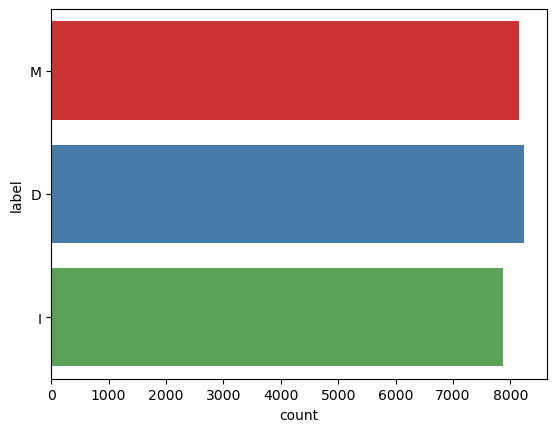

In [43]:
sns.countplot(y='label', data=df, palette="Set1")

### 2.2. Process Data

In [43]:
knee_angle_df = pd.read_csv("./knee_angle_2.csv")
knee_angle_df

,angle,label
0,82.006673,left_knee
1,74.160646,left_knee
2,73.564828,left_knee
3,73.541237,left_knee
4,71.950243,left_knee
...,...,...
9901,84.635022,right_knee
9902,88.030435,right_knee
9903,91.017440,right_knee
9904,96.022529,right_knee


<AxesSubplot:xlabel='angle', ylabel='label'>

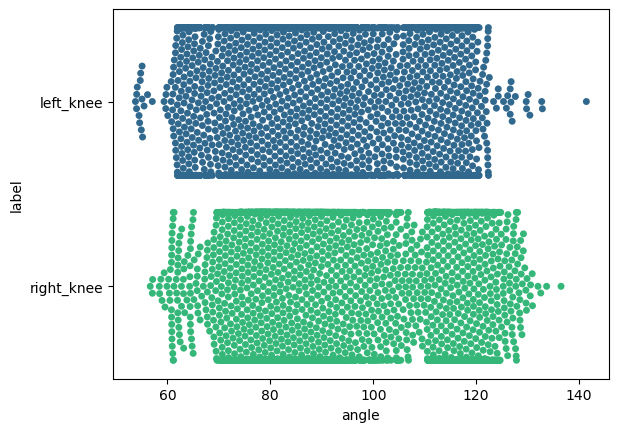

In [44]:
sns.swarmplot(x="angle", y="label", data=knee_angle_df, palette="viridis")

**Conclusion**

As seen from the 2 graph, the majority of knee angle fall between **60 <= angle <= 135**